In [1]:
import os, sys, rdflib
import numpy as np, pandas as pd
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import rdflib.plugins.sparql as sparql
from SPARQLWrapper import SPARQLWrapper, JSON
sys.path.append(os.path.abspath("./util"))
from misc import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import plotly.plotly as py
# import plotly.graph_objs as go
# from plotly.graph_objs import *

from sklearn import metrics
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering

In [2]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    dbpedia_type_graph = rdflib.Graph()
    dbpedia_type_graph.parse('./dataset/instance_types_en_uris_it.nt', format="nt" )
    dbpedia_type_graph.parse('./dataset/instance_types_en.nt', format="nt" )

CPU times: user 80.1 ms, sys: 12.7 ms, total: 92.8 ms
Wall time: 101 ms


In [3]:
%%time
# mapping freebase's mids to dbpedia's resources
mid2dbpedia = dict()
file_path = "./dataset/Release/freebase_code_names.txt"
with open(file_path, "r") as mapping_file:
    for line in mapping_file:
        mid, dbp_resource = line.replace("\n", "").split("\t")
        val = mid2dbpedia.get(mid, [])
        mid2dbpedia[mid] = val + [dbp_resource]

CPU times: user 298 ms, sys: 15.4 ms, total: 314 ms
Wall time: 405 ms


In [4]:
walks_path = "./dataset/Release/ttl/embedding_5_7_train.ttl.txt"

vocab_sequences = get_sequences(walks_path)
train_sequences = get_sequences(walks_path)

model = Word2Vec(min_count=1, window=5, negative=5, size=100)

model.build_vocab(vocab_sequences)
model.train(train_sequences)

418031

In [5]:
%%time
%store -r mid2types
if "mid2types" not in locals():
    mid2types = dict()
    for uri in model.vocab:
        mid = uri.replace("http://rdf.freebase.com/ns", "")
        if mid in mid2dbpedia:
            dbpedia_eqs = [uri[1:-1] for uri in mid2dbpedia[mid]]
            mid_types = {row[0].n3() for uri in dbpedia_eqs for row in get_types(uri, dbpedia_type_graph)}
            if len(mid_types) > 0:
                mid2types[mid] = mid_types
    %store mid2types

CPU times: user 218 µs, sys: 23 µs, total: 241 µs
Wall time: 234 µs


In [6]:
mid_prefix = "http://rdf.freebase.com/ns"

embeds = np.asarray([model[mid_prefix + mid] for mid in mid2types])
mids   = np.asarray([mid for mid in mid2types])
labels = np.asarray([1 if is_person(mid, mid2types) else 0 for mid in mid2types])

# random_idx = np.random.choice(range(len(embeds)), len(embeds), replace=False)
# split_point = len(embeds) * 70 / 100
# training_idx, test_idx = random_idx[:split_point], random_idx[split_point:]

# embeds_train, embeds_test = embeds[training_idx], embeds[test_idx]
# mids_train,   mids_test   = mids[training_idx], mids[test_idx]
# labels_train, labels_test = labels[training_idx], labels[test_idx]

tsne = TSNE(n_components=2)
%store -r twodims
if "twodims" not in locals():
    twodims = tsne.fit_transform(embeds)
    %store twodims

ground_truth = get_ground_truth(mids, mid2types)

colors  = [get_color(i) for i in ground_truth]

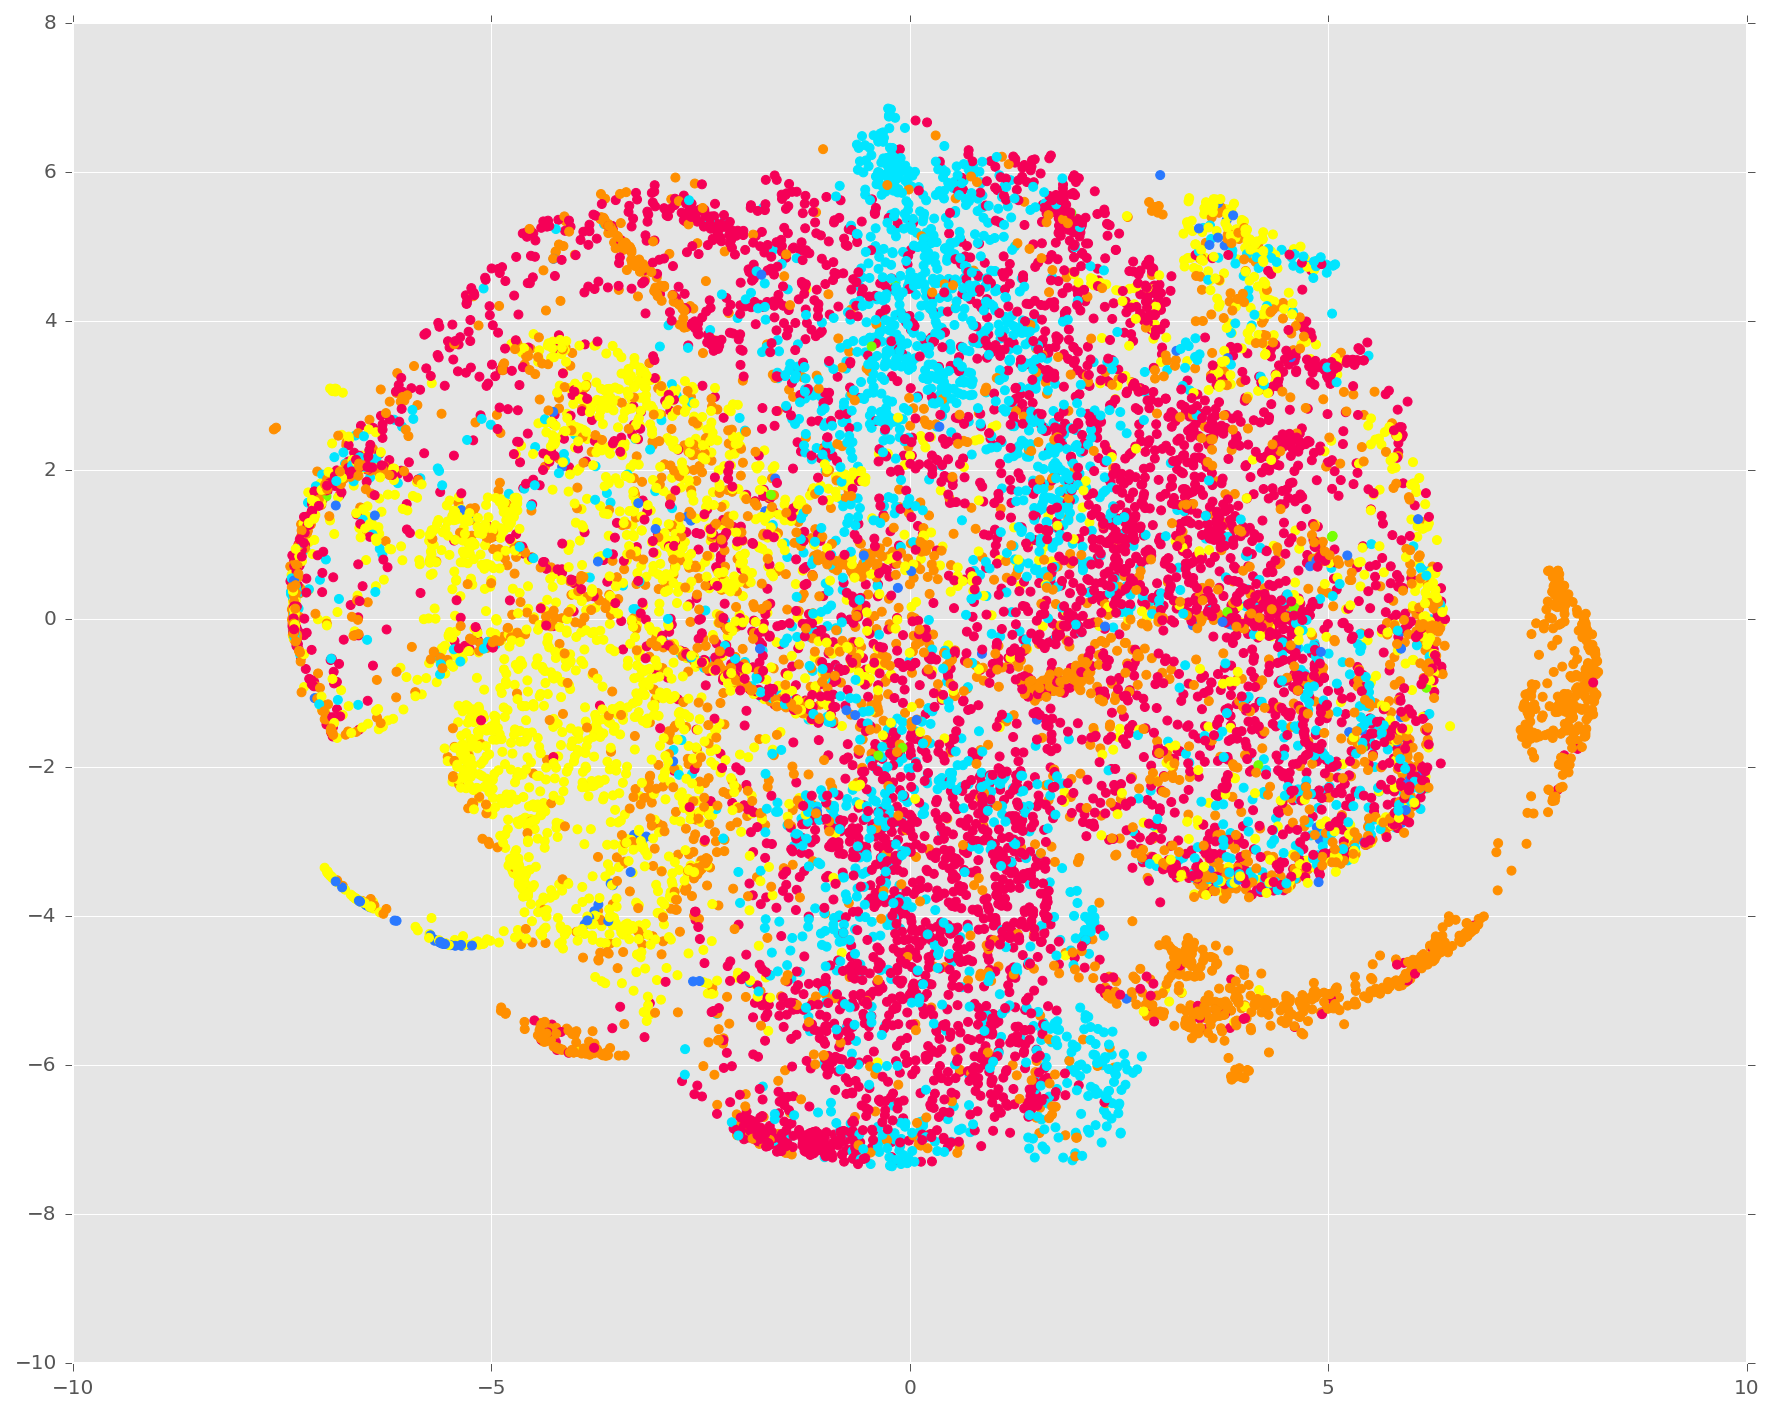

In [7]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=colors)
plt.show()

In [8]:
%%time
hdbscan = HDBSCAN(min_cluster_size=30)
dbscan  = DBSCAN(eps=0.4, min_samples=5)
kmeans  = KMeans(n_clusters=10)
spect   = SpectralClustering(n_clusters=7, eigen_solver='arpack', affinity="nearest_neighbors")
aggl    = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=7)

hdbscan_labels = hdbscan.fit_predict(embeds.astype(np.double))
dbscan_labels  = dbscan.fit_predict(embeds.astype(np.double))
kmeans_labels  = kmeans.fit_predict(embeds.astype(np.double))
spect_labels   = spect.fit_predict(embeds.astype(np.double))
aggl_labels    = aggl.fit_predict(embeds.astype(np.double))

cluster_colors = [get_color(clust) for clust in kmeans_labels]

CPU times: user 17min 44s, sys: 13.1 s, total: 17min 57s
Wall time: 13min 14s


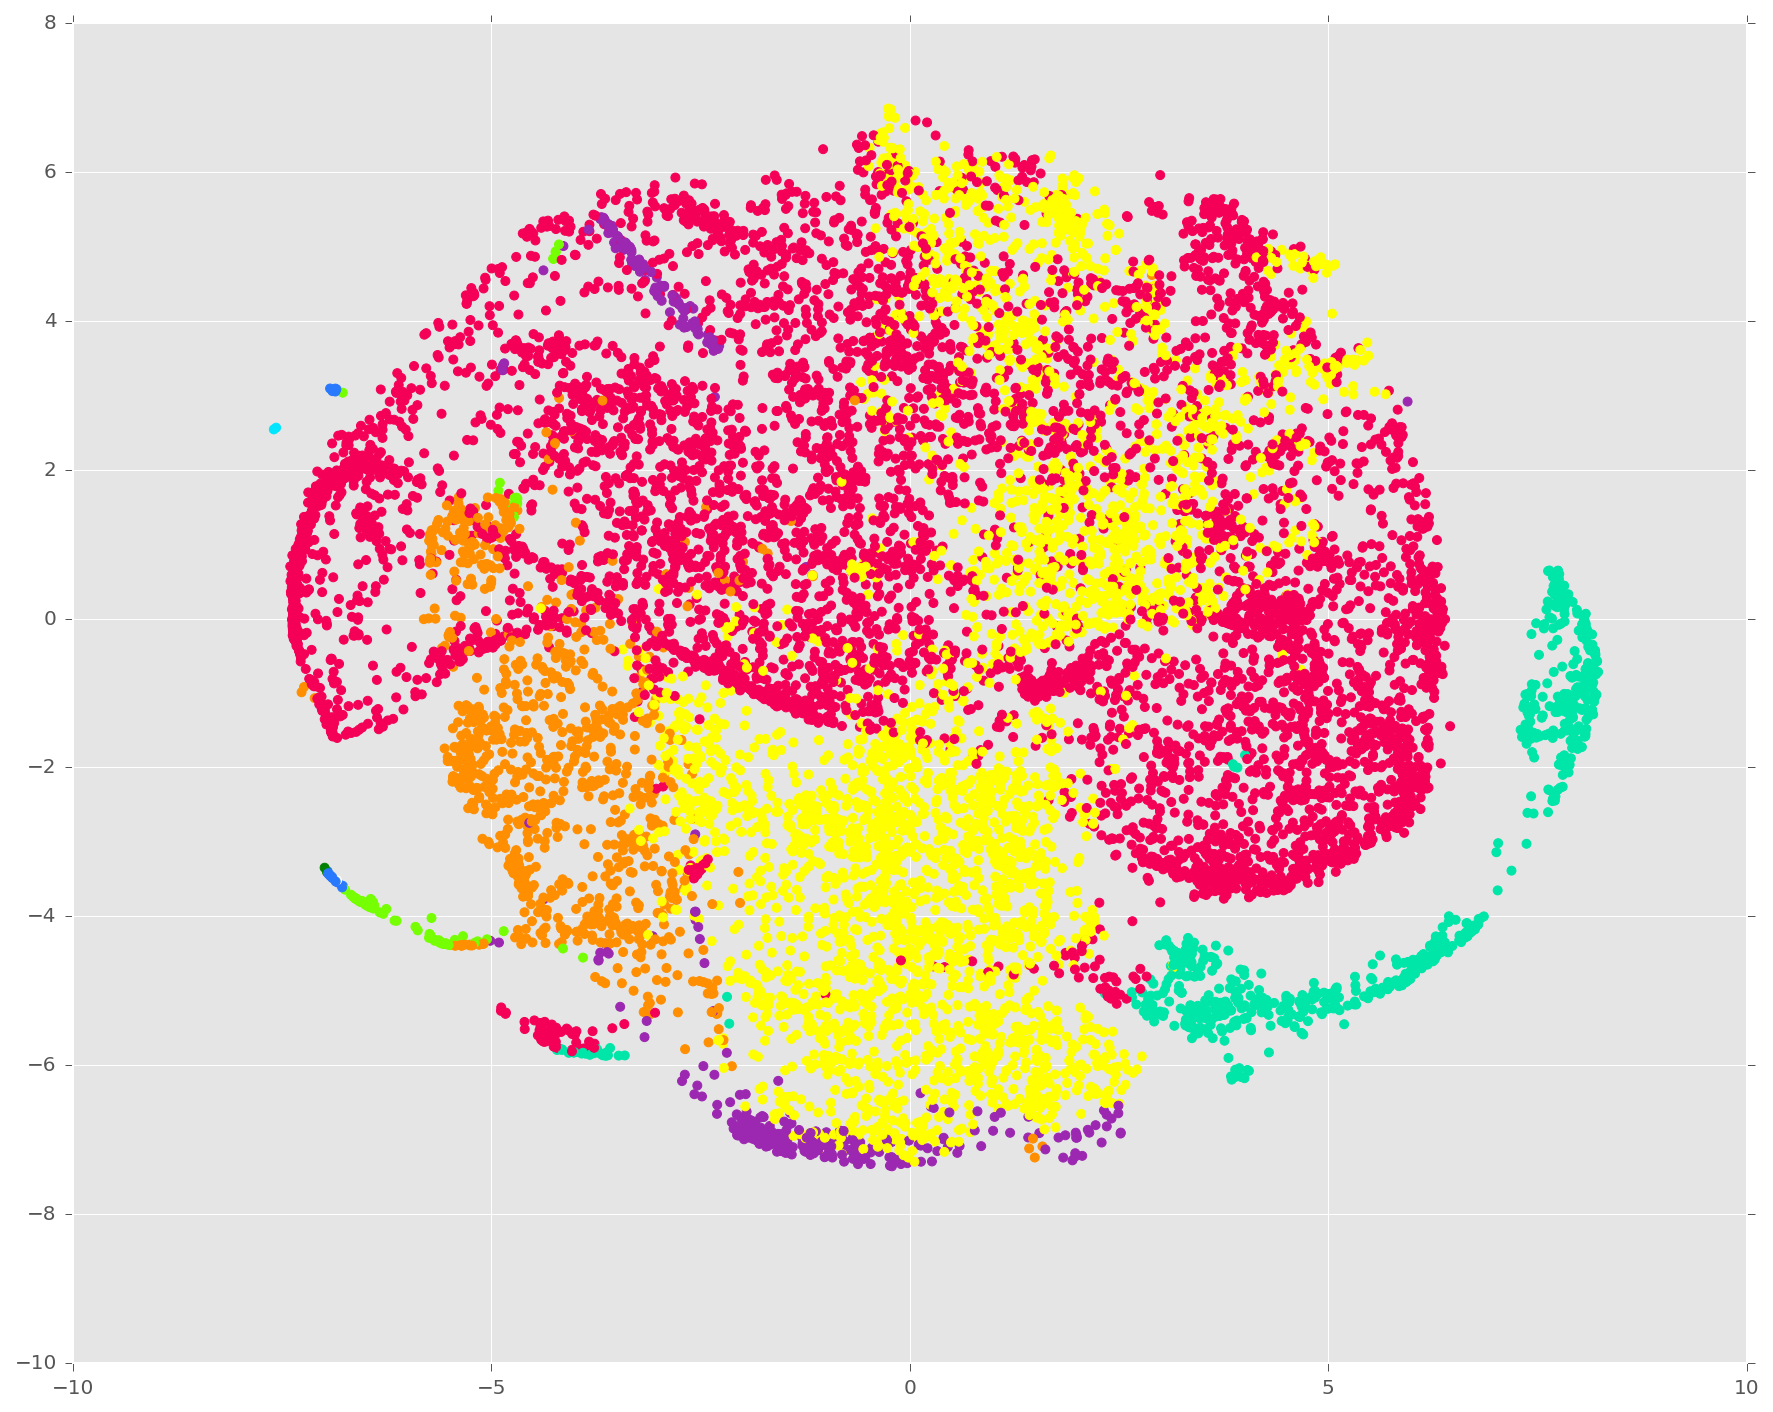

In [9]:
fig_size = [15, 12]
plt.rcParams["figure.figsize"] = fig_size
x = [point[0] for point in twodims]
y = [point[1] for point in twodims]
plt.scatter(x, y, color=cluster_colors)
plt.show()

In [10]:
metrics_df = pd.DataFrame([
        [   # hdbscan
            metrics.homogeneity_score(ground_truth, hdbscan_labels),
            metrics.completeness_score(ground_truth, hdbscan_labels),
            metrics.v_measure_score(ground_truth, hdbscan_labels),
            metrics.adjusted_rand_score(ground_truth, hdbscan_labels),
            metrics.adjusted_mutual_info_score(ground_truth, hdbscan_labels),
            metrics.silhouette_score(embeds, hdbscan_labels, metric='euclidean')
        ],
        [   # dbscan
            metrics.homogeneity_score(ground_truth, dbscan_labels),
            metrics.completeness_score(ground_truth, dbscan_labels),
            metrics.v_measure_score(ground_truth, dbscan_labels),
            metrics.adjusted_rand_score(ground_truth, dbscan_labels),
            metrics.adjusted_mutual_info_score(ground_truth, dbscan_labels),
            metrics.silhouette_score(embeds, dbscan_labels, metric='euclidean')
        ],
        [   # kmeans
            metrics.homogeneity_score(ground_truth, kmeans_labels),
            metrics.completeness_score(ground_truth, kmeans_labels),
            metrics.v_measure_score(ground_truth, kmeans_labels),
            metrics.adjusted_rand_score(ground_truth, kmeans_labels),
            metrics.adjusted_mutual_info_score(ground_truth, kmeans_labels),
            metrics.silhouette_score(embeds, kmeans_labels, metric='euclidean')
        ],
        [   # spect
            metrics.homogeneity_score(ground_truth, spect_labels),
            metrics.completeness_score(ground_truth, spect_labels),
            metrics.v_measure_score(ground_truth, spect_labels),
            metrics.adjusted_rand_score(ground_truth, spect_labels),
            metrics.adjusted_mutual_info_score(ground_truth, spect_labels),
            metrics.silhouette_score(embeds, spect_labels, metric='euclidean')
        ],
        [   # aggl
            metrics.homogeneity_score(ground_truth, aggl_labels),
            metrics.completeness_score(ground_truth, aggl_labels),
            metrics.v_measure_score(ground_truth, aggl_labels),
            metrics.adjusted_rand_score(ground_truth, aggl_labels),
            metrics.adjusted_mutual_info_score(ground_truth, aggl_labels),
            metrics.silhouette_score(embeds, aggl_labels, metric='euclidean')
        ]],
        index=[
            "hdbscan",
            "dbscan",
            "kmeans",
            "spectral",
            "agglomerative"
        ],
        columns=[
            "Homogeneity", 
            "Completeness", 
            "V-Measure core", 
            "Adjusted Rand index", 
            "Mutual Information",
            "Silhouette"
        ])

metrics_df

Homogeneity  Completeness  V-Measure core  Adjusted Rand index  \
hdbscan           0.004883      0.013844        0.007219             0.000957   
dbscan            0.002416      0.113639        0.004731             0.001536   
kmeans            0.162787      0.186657        0.173906             0.069748   
spectral          0.193105      0.215582        0.203725             0.117313   
agglomerative     0.000601      0.143566        0.001197             0.000114   

               Mutual Information  Silhouette  
hdbscan                  0.004609   -0.162566  
dbscan                   0.002284    0.914756  
kmeans                   0.161825    0.268920  
spectral                 0.192386    0.048143  
agglomerative            0.000091    0.945202

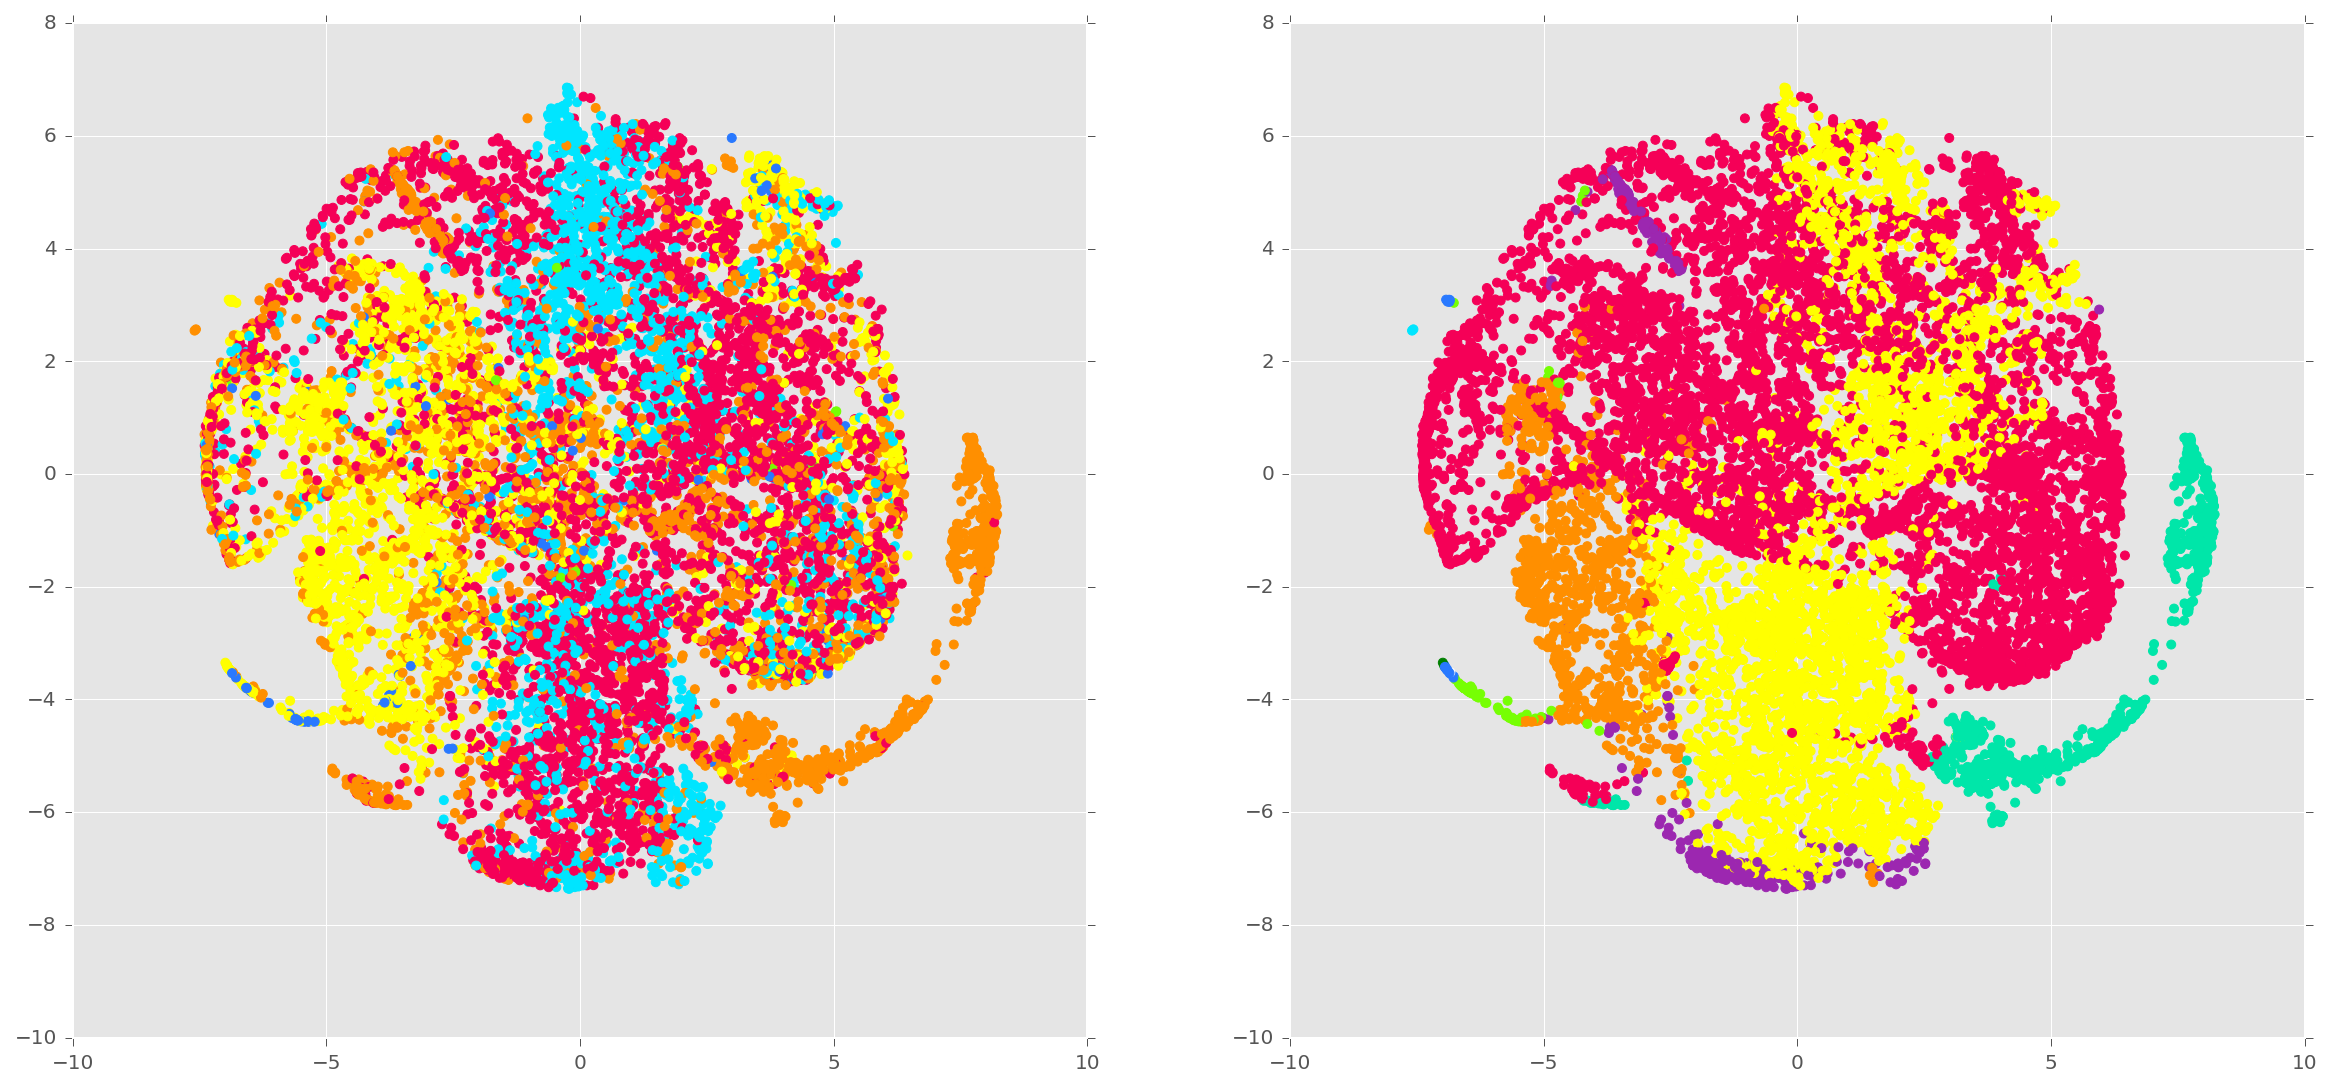

In [11]:
fig_size = [20, 20]
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots(nrows=1,ncols=2)
plt.subplot(2, 2, 1)
plt.scatter(x, y, color=colors)

plt.subplot(2, 2, 2)
plt.scatter(x, y, color=cluster_colors)
plt.show()